In [ ]:
!pip install seaborn
!pip install scikit-learn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Data import
dir_path = "data/"

In [ ]:
train_file = 'train_FD004.txt'
test_file = 'test_FD004.txt'
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD004.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

In [ ]:
print(train.shape)
train.head()

(61249, 26)


unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    42.0049     0.8400      100.0  445.00  549.68   
1        1            2    20.0020     0.7002      100.0  491.19  606.07   
2        1            3    42.0038     0.8409      100.0  445.00  548.95   
3        1            4    42.0000     0.8400      100.0  445.00  548.70   
4        1            5    25.0063     0.6207       60.0  462.54  536.10   

       s_3      s_4   s_5  ...    s_12     s_13     s_14     s_15  s_16  s_17  \
0  1343.43  1112.93  3.91  ...  129.78  2387.99  8074.83   9.3335  0.02   330   
1  1477.61  1237.50  9.35  ...  312.59  2387.73  8046.13   9.1913  0.02   361   
2  1343.12  1117.05  3.91  ...  129.62  2387.97  8066.62   9.4007  0.02   329   
3  1341.24  1118.03  3.91  ...  129.80  2388.02  8076.05   9.3369  0.02   328   
4  1255.23  1033.59  7.05  ...  164.11  2028.08  7865.80  10.8366  0.02   305   

   s_18    s_19   s_20     s_21  
0  2212  100.00  10.62   6.3670  
1  2324  100.00  24.37  14.6552  
2  2212  100.00  10.48   6.4213  
3  2212  100.00  10.54   6.4176  
4  1915   84.93  14.03   8.6754  

[5 rows x 26 columns]

### Adding remaining useful life

In [ ]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [ ]:
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

unit_nr  time_cycles  RUL
0        1            1  320
1        1            2  319
2        1            3  318
3        1            4  317
4        1            5  316

### Baseline model

In [ ]:
X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

# get last row of each engine
X_test = test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy() 

In [ ]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print(f'{label} set RMSE:{rmse:.2f}, R2:{variance:.2f}')

In [ ]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
y_hat_test = lm.predict(X_test)

In [ ]:
evaluate(y_train, y_hat_train, 'train')
evaluate(y_test, y_hat_test)

train set RMSE:60.29, R2:0.55
test set RMSE:47.76, R2:0.23


### Signal EDA for sensors

In [ ]:
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['setting_1'] = df_op_cond['setting_1'].round()
    df_op_cond['setting_2'] = df_op_cond['setting_2'].round(decimals=2)
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)
    
    return df_op_cond

In [ ]:
def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

In [ ]:
X_train_condition = add_operating_condition(train)
X_test_condition = add_operating_condition(X_test)

In [ ]:
X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

In [ ]:
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))
    
    if unit_nr:
        plt.plot('RUL', signal_name, 
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name, 
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

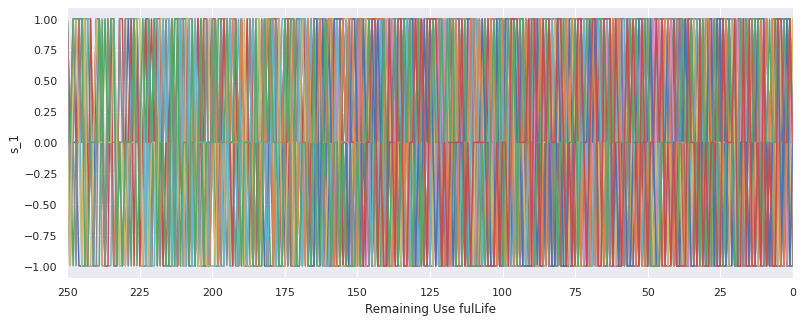

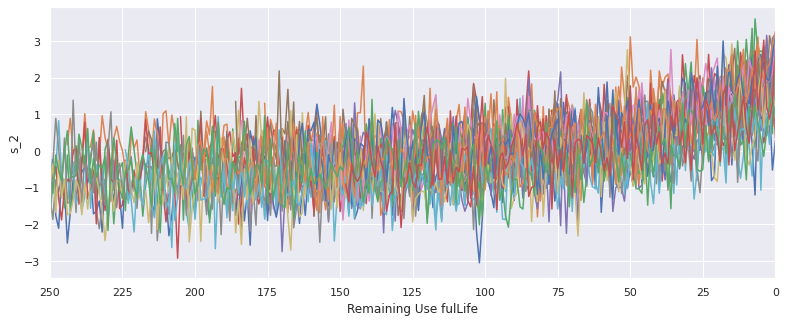

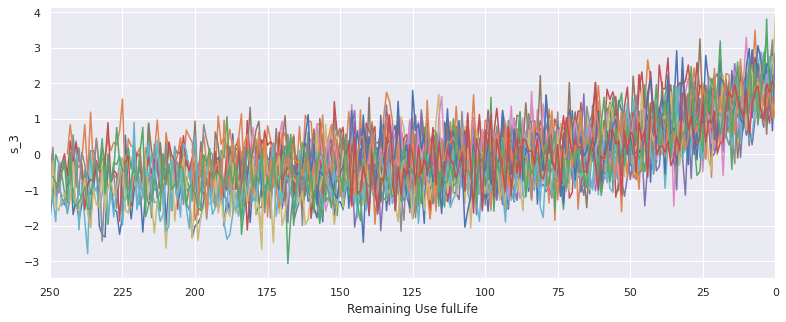

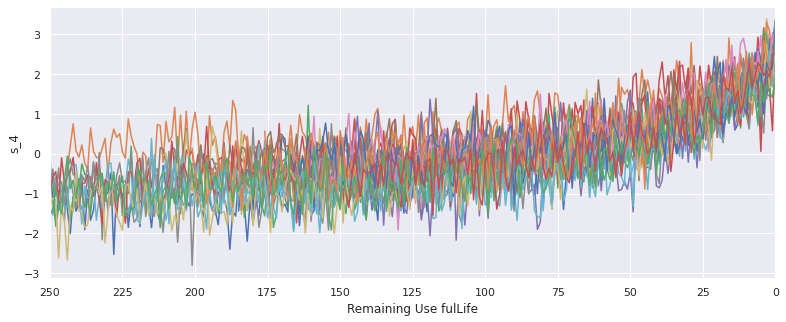

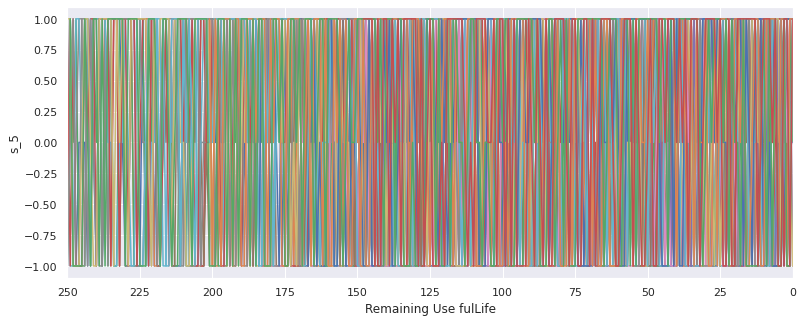

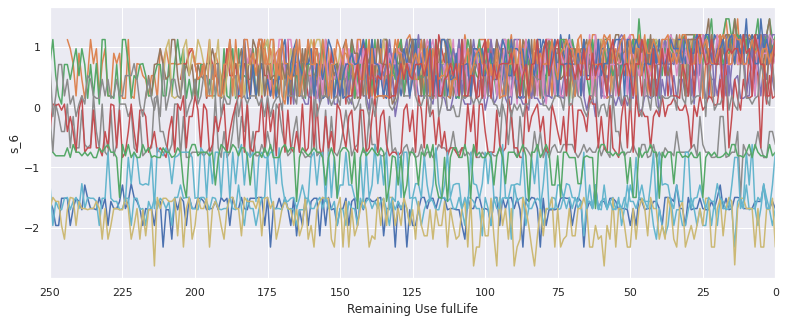

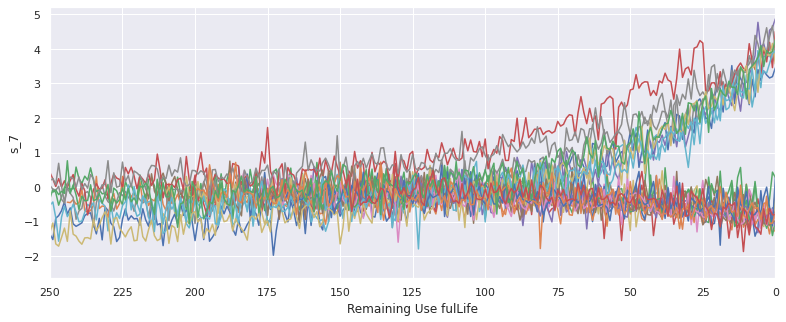

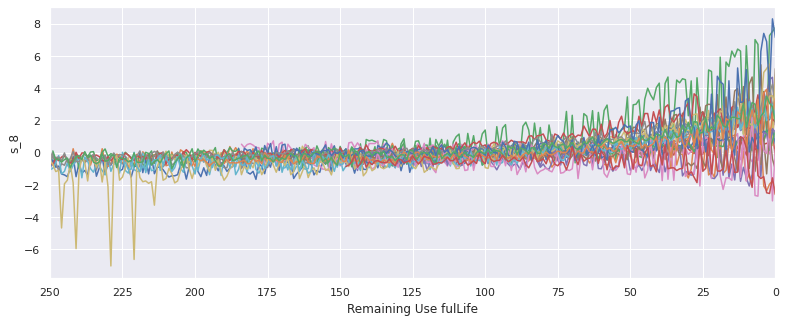

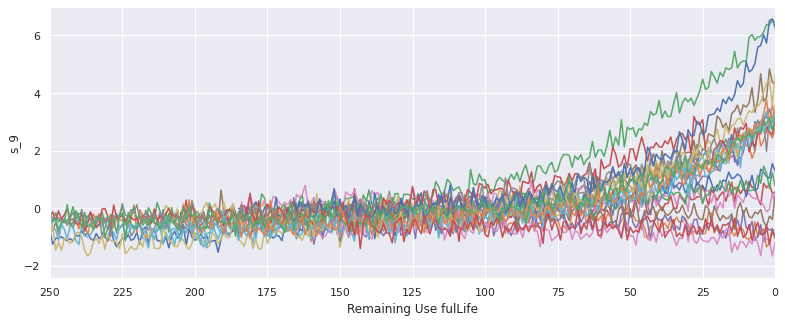

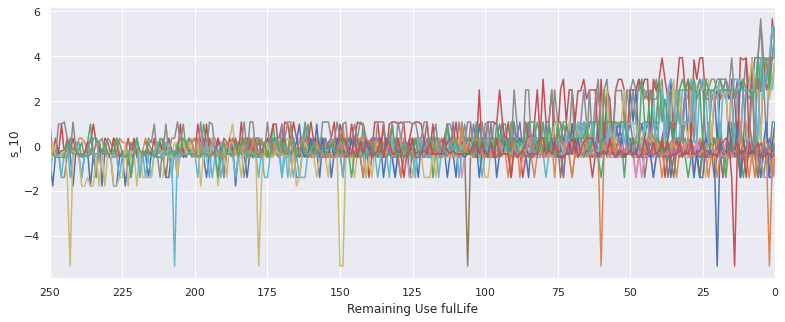

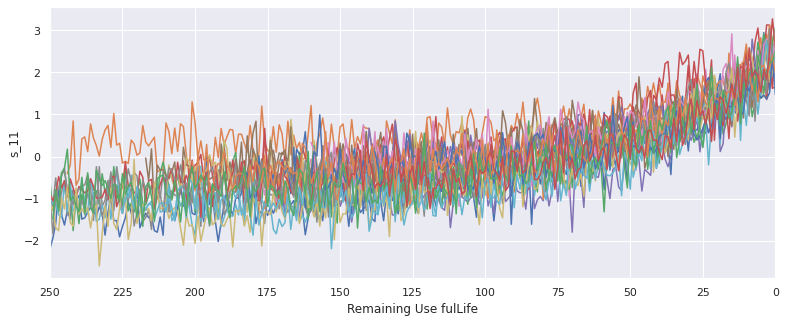

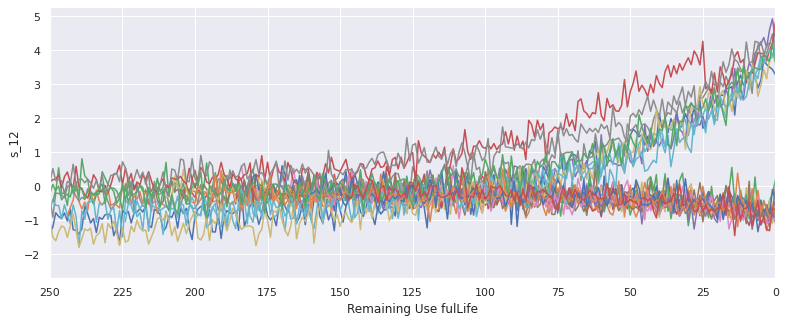

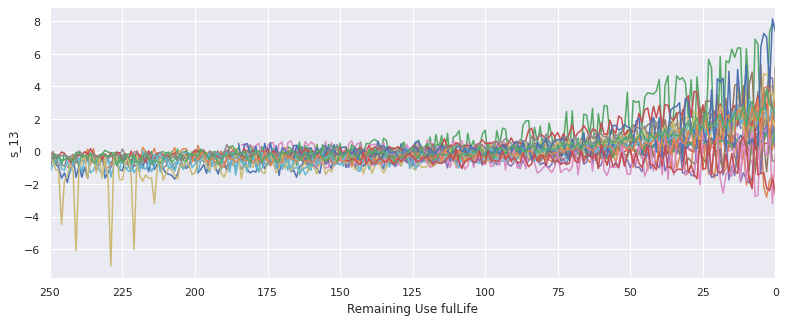

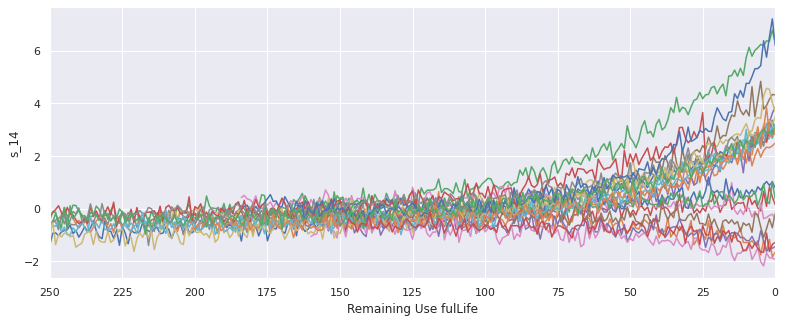

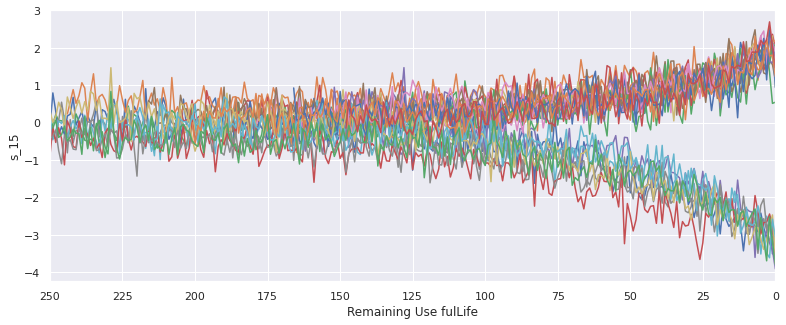

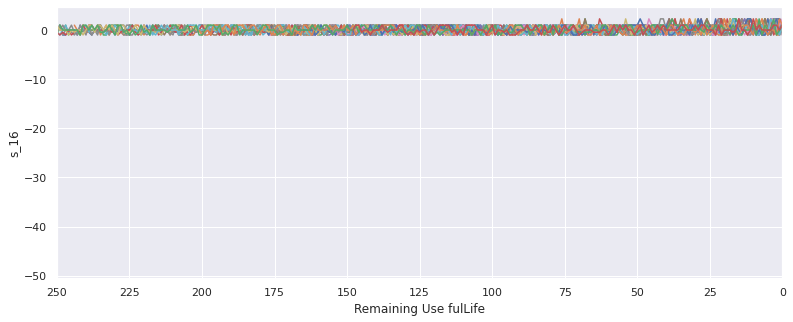

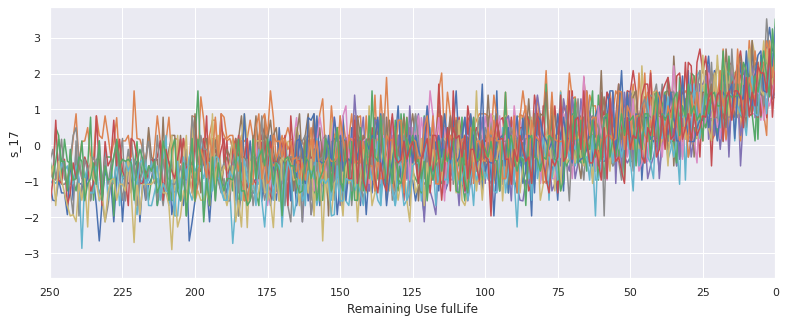

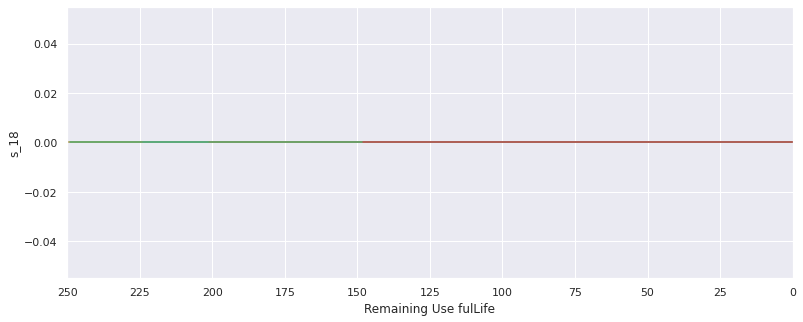

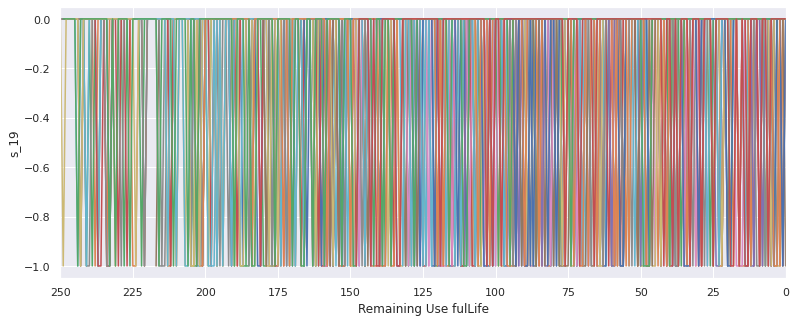

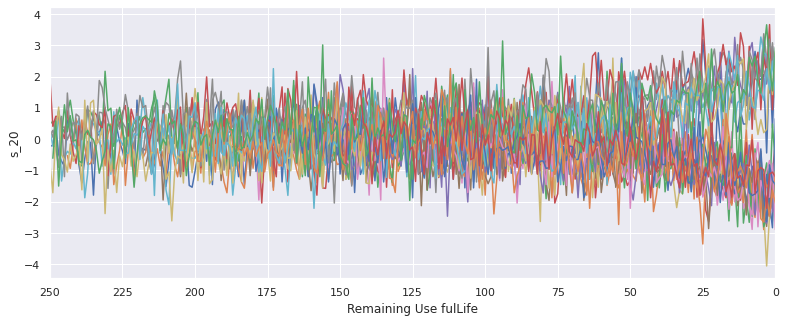

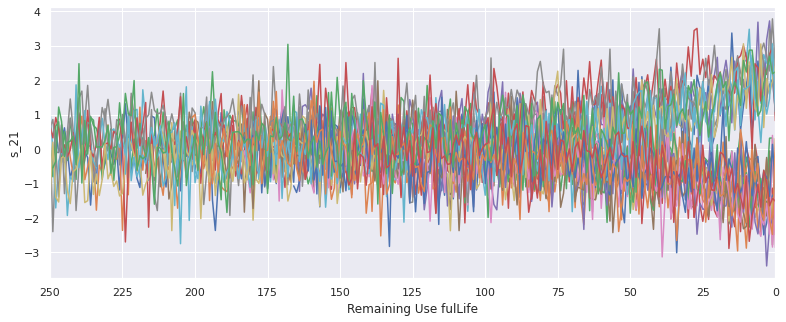

In [ ]:
for sensor in sensor_names:
    plot_signal(X_train_condition_scaled, sensor)

### Feature selection based on series EDA

In [ ]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

### Using LSTM for modeling

In [ ]:
example_df = pd.DataFrame.from_dict({"unit_nr": [1,1,1,1,1,2,2,2,2,2], "X":[10.0, 10.2, 10.4, 10.6, 10.8, 20.0, 20.2, 20.4, 20.6, 20.8], 
                                     "y":[1.4, 1.4, 1.3, 1.2, 1.1, 2.4, 2.4, 2.3, 2.2, 2.1]})

In [ ]:
#def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
#    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    #df_temp = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).values
    #print(df[sensors].shape)
    #print(df_temp.shape)
    #print("Temp array")
    #print(df_temp)
    #print("sensors array")
    #print(df[sensors])
    #df[sensors] = df_temp
#    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).values
    #df[sensors] = df_temp #df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
#    def create_mask(data, samples):
#        result = np.ones_like(data)
#        result[0:samples] = 0
#        return result
    
#    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
#    df = df[mask]
    
#    return df

In [ ]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).values
   
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  # eventhough we set np and tf seeds, gss requires its own seed

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique())
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

### Generating series to ensure sequences are from indivdual units

In [ ]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

In [ ]:
gen = gen_train_data(example_df[example_df['unit_nr']==1], sequence_length=4, columns=['X'])
list(gen)

[array([[10. ],
        [10.2],
        [10.4],
        [10.6]]),
 array([[10.2],
        [10.4],
        [10.6],
        [10.8]])]

In [ ]:
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [ ]:
data_array = gen_data_wrapper(example_df, sequence_length=4, columns=['X'])
data_array

array([[[10. ],
        [10.2],
        [10.4],
        [10.6]],

       [[10.2],
        [10.4],
        [10.6],
        [10.8]],

       [[20. ],
        [20.2],
        [20.4],
        [20.6]],

       [[20.2],
        [20.4],
        [20.6],
        [20.8]]], dtype=float32)

In [ ]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

In [ ]:
def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [ ]:
label = gen_labels(example_df[example_df['unit_nr']==1], sequence_length=4, label=['y'])
label

array([[1.2],
       [1.1]])

In [ ]:
label_array = gen_label_wrapper(example_df, sequence_length=4, label=['y'])
label_array

array([[1.2],
       [1.1],
       [2.2],
       [2.1]], dtype=float32)

In [ ]:
# padding example
a = np.full(shape=(5,3), fill_value=-99.)  # desired sequence length
b = np.full(shape=(2,3), fill_value=0.)  # available sequence length

idx = a.shape[0] - b.shape[0]  # equals to 3

a[idx:,:] = b
a

array([[-99., -99., -99.],
       [-99., -99., -99.],
       [-99., -99., -99.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.]])

Padding for sequence data

In [ ]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]

In [ ]:
gen = (list(gen_test_data(example_df[example_df['unit_nr']==unit_nr], sequence_length=6, columns=['X'], mask_value=-99.))
           for unit_nr in example_df['unit_nr'].unique())

In [ ]:
next(gen)

[array([[-99. ],
        [ 10. ],
        [ 10.2],
        [ 10.4],
        [ 10.6],
        [ 10.8]])]

### Preprocessing for model training

In [ ]:
sequence_length = 20
train['RUL'].clip(upper=125, inplace=True)

X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
    train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['unit_nr'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
    
    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

# create sequences train, test 
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

### LSTM Model

In [ ]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights.h5')

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')  # the model is recompiled to reset the optimizer
model.load_weights('simple_lstm_weights.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=5,
                   batch_size=32)

Epoch 1/5
1423/1423 [==============================] - 19s 9ms/step - loss: 7048.3446 - val_loss: 3055.8511
Epoch 2/5
1423/1423 [==============================] - 11s 8ms/step - loss: 2470.7582 - val_loss: 1083.1022
Epoch 3/5
1423/1423 [==============================] - 11s 8ms/step - loss: 823.8197 - val_loss: 521.3510
Epoch 4/5
1423/1423 [==============================] - 11s 8ms/step - loss: 358.5644 - val_loss: 403.9085
Epoch 5/5
1423/1423 [==============================] - 11s 8ms/step - loss: 269.8030 - val_loss: 380.3910


In [ ]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

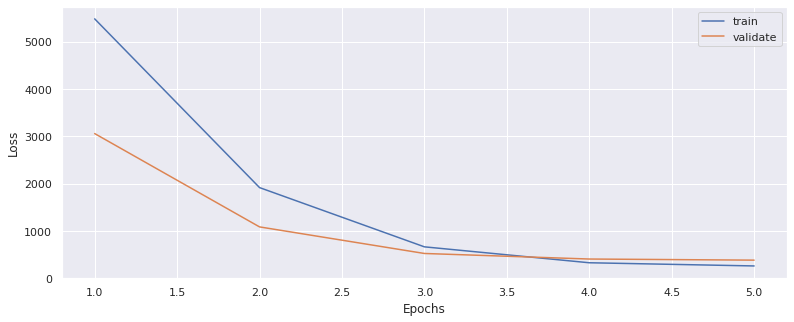

In [ ]:
plot_loss(history)

In [ ]:
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)

train set RMSE:16.37, R2:0.84
test set RMSE:28.59, R2:0.73


## Hyperparameter tuning

In [ ]:
# I know lower alpha's perform better, so we can ditch a few high ones to reduce the search space
alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)

sequence_list = list(np.arange(10,40+1,5))
epoch_list = list(np.arange(5,20+1,5))
nodes_list = [[32], [64], [128], [256], [32, 64], [64, 128], [128, 256]]

# lowest dropout=0.1, because I know zero dropout will yield better training results but worse generalization
dropouts = list(np.arange(1,5)/10)  

# again, earlier testing revealed relu performed significantly worse, so I removed it from the options
activation_functions = ['tanh', 'sigmoid']
batch_size_list = [32, 64, 128, 256]
sensor_list = [['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'],
               ['s_2', 's_3', 's_4', 's_7', 's_11', 's_12', 's_15', 's_17', 's_20', 's_21']]

tuning_options = np.prod([len(alpha_list),
                          len(sequence_list),
                          len(epoch_list),
                          len(nodes_list),
                          len(dropouts),
                          len(activation_functions),
                          len(batch_size_list),
                          len(sensor_list)])

In [ ]:
def prep_data(train, test, drop_sensors, remaining_sensors, alpha):
    X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
    X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha)
    
    return X_train_interim, X_test_interim

In [ ]:
# input_shape = (sequence_length, train_array.shape[2])
def create_model(input_shape, nodes_per_layer, dropout, activation, weights_file):
    model = Sequential()
    model.add(Masking(mask_value=-99., input_shape=input_shape))
    if len(nodes_per_layer) <= 1:
        model.add(LSTM(nodes_per_layer[0], activation=activation))
        model.add(Dropout(dropout))
    else:
        model.add(LSTM(nodes_per_layer[0], activation=activation, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(nodes_per_layer[1], activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save_weights(weights_file)
    return model

In [ ]:
# Save whole model

model.save("lstm_pipline")

INFO:tensorflow:Assets written to: lstm_pipline/assets


INFO:tensorflow:Assets written to: lstm_pipline/assets


In [ ]:
model.save("lstm_pipline.h5")

In [ ]:
# Load file
new_model = tf.keras.models.load_model("lstm_pipeline.h5")

NameError: name 'keras' is not defined

ITERATIONS = 60

results = pd.DataFrame(columns=['MSE', 'std_MSE', 'alpha', # bigger std means less robust
                                'epochs', 'nodes', 'dropout', 
                                'activation', 'batch_size', 
                                'sequence_length', 'sensor_length'])  

weights_file = 'lstm_hyper_parameter_weights.h5'


for i in range(ITERATIONS):
    if ITERATIONS < 10:
        print('iteration ', i+1)
    elif ((i+1) % 10 == 0):
        print('iteration ', i+1)
    
    mse = []
    
    # init parameters
    alpha = random.sample(alpha_list, 1)[0]
    sequence_length = random.sample(sequence_list, 1)[0]
    epochs = random.sample(epoch_list, 1)[0]
    nodes_per_layer = random.sample(nodes_list, 1)[0]
    dropout = random.sample(dropouts, 1)[0]
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_size_list, 1)[0]
    remaining_sensors = random.sample(sensor_list, 1)[0]
    drop_sensors = [element for element in sensor_names if element not in remaining_sensors]
    
    # create model
    input_shape = (sequence_length, len(remaining_sensors))
    model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)
    
    # create train-val split
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
    gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
    for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
        train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
        train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
        train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
        
        val_unit = X_train_interim['unit_nr'].unique()[val_unit]
        val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
        val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)
        
        # train and evaluate model
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration
        
        history = model.fit(train_split_array, train_split_label,
                            validation_data=(val_split_array, val_split_label),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)
        mse.append(history.history['val_loss'][-1])
    
    # append results
    d = {'MSE':np.mean(mse), 'std_MSE':np.std(mse), 'alpha':alpha, 
         'epochs':epochs, 'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'sequence_length':sequence_length,
         'sensor_length':len(remaining_sensors)}
    results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)

In [ ]:
tf.__version__

'2.4.1'